# This workbook outlines queries and coding necessary to answer questions for a supplied SQL dataset.

# Section 1: SQL

1) Count the number of states

In [ ]:
SELECT DISTINCT(COUNT(*))
FROM STATES;

[9]

2) Find the state(s) with the most cities

In [ ]:
SELECT states.name, COUNT(*)
FROM states 
JOIN cities on  states.id = cities.state_id
GROUP BY states.name
ORDER BY COUNT DESC;

[California and New York are tied, both have two cities.]

3) Assume the city ID ranks the cities in the order the company launched (hypothetically)
- i. Find the state that was launched first

In [ ]:
SELECT states.name
FROM states
JOIN cities on cities.state_id = states.id
ORDER by cities.id ASC
LIMIT 1;

[Massachusetts]

ii. Find the state that was launched last

In [ ]:
SELECT cities.name
FROM states
JOIN cities on cities.state_id = states.id
WHERE cities.id = 3;

[Los Angeles]

Format of query as I already had code from previous query.  Alternatively we could limit query to cities table:

In [ ]:
SELECT name
FROM cities
WHERE cities.id = 3;

[Los Angeles]

4) i. What is the average population of the cities the company is in?

In [ ]:
#Assuming that all cities entered in cities table are active metros.
SELECT AVG(population)
FROM cities;

ii. What is the largest population of the first five cities launched?

In [ ]:
SELECT name, MAX(population)
FROM cities
WHERE id <= 5
GROUP BY name
ORDER BY MAX DESC
LIMIT 1;

[Los Angeles with a population of 3,884,000]

5) For every city, calculate the percentage size of the city relative to the city with the largest population in the state. 

In [ ]:
SELECT states.name, cities.name, cities.population, MAX(population)
    OVER (PARTITION BY state_id) AS max_state_population,
    (CAST(population AS float) / (MAX(population)
    OVER (PARTITION BY state_id))*100)
FROM cities
JOIN states ON states.id = cities.state_id
ORDER BY states.name;

6) Calculate the running average population of the last 2 cities launched for every city in the table (e.g., the average of the city and
the city launched before)
HINT: Use a window function

In [ ]:
SELECT id, name, population, AVG(population)
OVER (ORDER BY id ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS running_avg_population
FROM cities;

# Section II: Python & Geo-Spatial Visualization

In [1]:
import psycopg2 as pg2
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Connect to local PostrgreSQL server to pull data provided for case study
# Joined data in SQL
conn = pg2.connect(database='db',user='postgres',password='')
db = conn.cursor()
db.execute('SELECT * FROM states JOIN cities on states.id = cities.state_id')
db = db.fetchall()
#created dataframe from query and established column names here as well.
df = pd.DataFrame(data=db)
col0 = db.description[0][0]
col1 = db.description[1][0]
col2 = db.description[2][0]
col3 = db.description[3][0]
col4 = db.description[4][0]
col5 = db.description[5][0]
col6 = db.description[6][0]
df.columns = (col0, col1, col2, col3, col4, col5, col6)
conn.close()

In [5]:
#resulting dataframe
df

,id,name,abbrev,id,name,state_id,population
0,1,Massachussetts,MA,1,Boston,1,645966
1,2,Nevada,NV,2,Las Vegas,2,603488
2,3,California,CA,3,Los Angeles,3,3884000
3,3,California,CA,4,San Diego,3,1356000
4,4,Missouri,MO,5,Kansas City,4,467007
5,5,Kansas,KS,6,Kansas City,5,148483
6,6,Pennsylvania,PA,7,Philadelphia,6,1553000
7,7,Florida,FL,8,Miami,7,417650
8,8,District of Columbia,DC,9,Washington,8,658893
9,9,New York,NY,10,Manhattan,9,1626000


In [6]:
#dropped initial ID column as it is redundant, we already have state_id
df = df.ix[:,1:]

In [7]:
#list out existing column names
df.columns

Index([u'name', u'abbrev', u'id', u'name', u'state_id', u'population'], dtype='object')

In [8]:
#renamed to avoid any confusion
df.columns = [u'state', u'abbrev', u'id', u'city', u'state_id', u'population']

In [9]:
df

,state,abbrev,id,city,state_id,population
0,Massachussetts,MA,1,Boston,1,645966
1,Nevada,NV,2,Las Vegas,2,603488
2,California,CA,3,Los Angeles,3,3884000
3,California,CA,4,San Diego,3,1356000
4,Missouri,MO,5,Kansas City,4,467007
5,Kansas,KS,6,Kansas City,5,148483
6,Pennsylvania,PA,7,Philadelphia,6,1553000
7,Florida,FL,8,Miami,7,417650
8,District of Columbia,DC,9,Washington,8,658893
9,New York,NY,10,Manhattan,9,1626000


In [10]:
#pulled list of cities from dataframe
cities = df['city'].tolist()
cities

['Boston',
 'Las Vegas',
 'Los Angeles',
 'San Diego',
 'Kansas City',
 'Kansas City',
 'Philadelphia',
 'Miami',
 'Washington',
 'Manhattan',
 'Brooklyn']

In [11]:
#using geopy to get latitude and longtitude for cities
from geopy.geocoders import Nominatim
lat_list = []
long_list = []

def LatLong(values):
    for x in values:
        geolocator = Nominatim()
        location = geolocator.geocode(x)
        lat_list.append(location.latitude)
        long_list.append(location.longitude)

In [12]:
#run function with cities from existing dataframe
LatLong(cities)

In [13]:
#add output from function to existing dataframe
df['latitude'] = lat_list
df['longitude'] = long_list

In [14]:
#updated dataframe below
df

,state,abbrev,id,city,state_id,population,latitude,longitude
0,Massachussetts,MA,1,Boston,1,645966,42.360482,-71.059568
1,Nevada,NV,2,Las Vegas,2,603488,36.166286,-115.149225
2,California,CA,3,Los Angeles,3,3884000,34.054935,-118.244476
3,California,CA,4,San Diego,3,1356000,32.717421,-117.162771
4,Missouri,MO,5,Kansas City,4,467007,39.084469,-94.563030
5,Kansas,KS,6,Kansas City,5,148483,39.084469,-94.563030
6,Pennsylvania,PA,7,Philadelphia,6,1553000,39.952399,-75.163590
7,Florida,FL,8,Miami,7,417650,25.774266,-80.193659
8,District of Columbia,DC,9,Washington,8,658893,38.894955,-77.036646
9,New York,NY,10,Manhattan,9,1626000,40.790278,-73.959722


In [15]:
df['population'].sum()

13952487

In [16]:
def national(x):
    return (x /(13952487.0))

In [17]:
df['national_population'] = df['population'].apply(national)

In [18]:
df

,state,abbrev,id,city,state_id,population,latitude,longitude,national_population
0,Massachussetts,MA,1,Boston,1,645966,42.360482,-71.059568,0.046298
1,Nevada,NV,2,Las Vegas,2,603488,36.166286,-115.149225,0.043253
2,California,CA,3,Los Angeles,3,3884000,34.054935,-118.244476,0.278373
3,California,CA,4,San Diego,3,1356000,32.717421,-117.162771,0.097187
4,Missouri,MO,5,Kansas City,4,467007,39.084469,-94.563030,0.033471
5,Kansas,KS,6,Kansas City,5,148483,39.084469,-94.563030,0.010642
6,Pennsylvania,PA,7,Philadelphia,6,1553000,39.952399,-75.163590,0.111306
7,Florida,FL,8,Miami,7,417650,25.774266,-80.193659,0.029934
8,District of Columbia,DC,9,Washington,8,658893,38.894955,-77.036646,0.047224
9,New York,NY,10,Manhattan,9,1626000,40.790278,-73.959722,0.116538


2) On a map of the US, plot a point on each of the cities 
cities with the point size relative to population size in 
the following three ways:
i. Showing a map that contains the entire US.

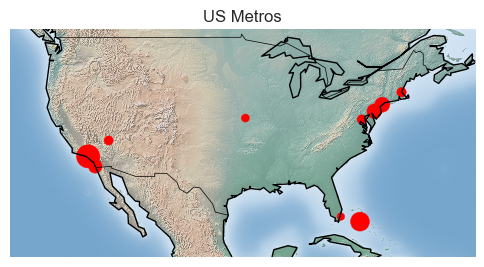

In [21]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
 
m = Basemap(projection='mill', 
            llcrnrlat=20,
            llcrnrlon=-130,
            urcrnrlat=50,
            urcrnrlon=-60)
m.drawcountries()
m.drawcoastlines()
# m.drawstates(color='black')

lon = df['longitude'].values
lat = df['latitude'].values
size = df['national_population'].values
    
xs, ys = m(lon, lat)
m.scatter(xs, ys, marker = 'o', color = 'red', s=size*1000)


m.shadedrelief()

plt.legend
plt.title('US Metros')
plt.show()

ii. Showing a map that contains only West 
Coast cities (Las Vegas, Los Angeles, and San Diego).

In [22]:
#slicing existing dataframe to only include west coast cities
westcoast = df.ix[(df['city']=='Las Vegas') | (df['city']=='Los Angeles') | (df['city']=='San Diego')]
westcoast

,state,abbrev,id,city,state_id,population,latitude,longitude,national_population
1,Nevada,NV,2,Las Vegas,2,603488,36.166286,-115.149225,0.043253
2,California,CA,3,Los Angeles,3,3884000,34.054935,-118.244476,0.278373
3,California,CA,4,San Diego,3,1356000,32.717421,-117.162771,0.097187


In [23]:
#determining population of west coast cities to determine point size
westcoast['population'].sum()

5843488

In [24]:
def westpop(x):
    return (x /(5843488.0))
westcoast['westcoast_pop'] = westcoast['population'].apply(westpop)
westcoast

/Users/danieldemoray/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,state,abbrev,id,city,state_id,population,latitude,longitude,national_population,westcoast_pop
1,Nevada,NV,2,Las Vegas,2,603488,36.166286,-115.149225,0.043253,0.103275
2,California,CA,3,Los Angeles,3,3884000,34.054935,-118.244476,0.278373,0.664672
3,California,CA,4,San Diego,3,1356000,32.717421,-117.162771,0.097187,0.232053


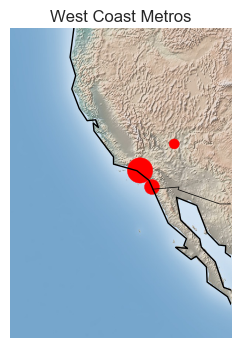

In [26]:
m = Basemap(projection='mill', 
            llcrnrlat=20,
            llcrnrlon=-130,
            urcrnrlat=45,
            urcrnrlon=-110)
m.drawcountries()
m.drawcoastlines()
# m.drawstates(color='black')

lon = westcoast['longitude'].values
lat = westcoast['latitude'].values
size = westcoast['westcoast_pop'].values
    
xs, ys = m(lon, lat)
m.scatter(xs, ys, marker = 'o', color = 'red', s=size*500)


m.shadedrelief()

plt.legend
plt.title('West Coast Metros')
plt.show()

iii. Showing a map that contains only Northeast 
cities (Boston, Philadelphia, Washington, Manhattan, and Brooklyn).

In [27]:
northeast = df.ix[(df['city']=='Boston') | (df['city']=='Philadelphia') | (df['city']=='Washington') | (df['city']=='Manhattan') | (df['city']=='Brooklyn')]
northeast

,state,abbrev,id,city,state_id,population,latitude,longitude,national_population
0,Massachussetts,MA,1,Boston,1,645966,42.360482,-71.059568,0.046298
6,Pennsylvania,PA,7,Philadelphia,6,1553000,39.952399,-75.163590,0.111306
8,District of Columbia,DC,9,Washington,8,658893,38.894955,-77.036646,0.047224
9,New York,NY,10,Manhattan,9,1626000,40.790278,-73.959722,0.116538
10,New York,NY,11,Brooklyn,9,2592000,25.060130,-77.312482,0.185773


In [28]:
#determining population of northeast cities to determine point size
northeast['population'].sum()

7075859

In [29]:
def northeastpop(x):
    return (x /(7075859.0))
northeast['northeast_pop'] = northeast['population'].apply(northeastpop)
northeast

/Users/danieldemoray/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,state,abbrev,id,city,state_id,population,latitude,longitude,national_population,northeast_pop
0,Massachussetts,MA,1,Boston,1,645966,42.360482,-71.059568,0.046298,0.091292
6,Pennsylvania,PA,7,Philadelphia,6,1553000,39.952399,-75.163590,0.111306,0.219479
8,District of Columbia,DC,9,Washington,8,658893,38.894955,-77.036646,0.047224,0.093118
9,New York,NY,10,Manhattan,9,1626000,40.790278,-73.959722,0.116538,0.229795
10,New York,NY,11,Brooklyn,9,2592000,25.060130,-77.312482,0.185773,0.366316


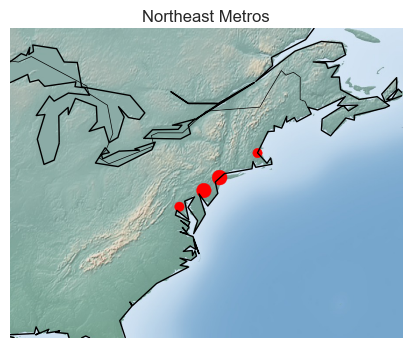

In [30]:
m = Basemap(projection='mill', 
            llcrnrlat=30,
            llcrnrlon=-90,
            urcrnrlat=50,
            urcrnrlon=-60)
m.drawcountries()
m.drawcoastlines()
# m.drawstates(color='black')

lon = northeast['longitude'].values
lat = northeast['latitude'].values
size = northeast['northeast_pop'].values
    
xs, ys = m(lon, lat)
m.scatter(xs, ys, marker = 'o', color = 'red', s=size*500)


m.shadedrelief()

plt.legend
plt.title('Northeast Metros')
plt.show()